# Simulação de um sistema de EDO

Os modelos matemáticos representam uma aproximação de mundo do real. No caso de processos químicos, eles podem auxiliar em diversas tarefas do engenheiro, como projetar equipamentos, determinar a condição operacional ótima, analisar o comportamento dinâmico e propor estratégias de controle. Para isso, uma etapa fundamental é a simulação dos modelos com o auxílio do computador.

Dada a diversidade da natureza matemática dos modelos, existem muitas técnicas numéricas para a resolução das equações. Aqui, será considerada apenas a integração numérica de um sistema de equações diferenciais ordinárias (EDO) de primeira ordem, em que a variável independente é o tempo:

$$ \frac{dx}{dt}=f(t,x,u)$$
$$ x(t_0 )=x_0 $$

em que $f( )$ representa um sistema de equações; $t$, a variável independente tempo;
 $x$, o vetor de variáveis dependentes ou de estado com a condição inicial $x_0$ em $t=t_0$; e $u$, o vetor de variáveis de entrada.

Muitos problemas dinâmicos podem ser representados por este tipo de equação, como aqueles que envolvem tanques de mistura e reatores (batelada e tipo tanque agitado). De qualquer forma, equações de ordem superior podem ser reescritas na forma acima e sistemas de equações diferenciais parciais (EDP) podem ser transformados em um sistema de EDO, por exemplo, aplicando-se diferenças finitas.

A solução deste tipo de problema no Python, pode ser feita em duas partes:

* A primeira é a implementação de uma função com as equações $f(t,x,u)$, que aceita a variável independente, as variáveis dependentes e quaisquer parâmetros necessários e retorna os valores das derivadas $dx/dt$ das variáveis dependentes.
* A segunda parte integra a função com o integrador solve_ivp da biblioteca SciPy (scipy.integrate) para calcular soluções das variáveis dependentes em um intervalo de tempo especificado, assumindo as condições iniciais fornecidas.

Assim, a partir da condição inicial $x(t_0 )=x_0$, é possível conhecer o comportamento dinâmico das variáveis de estado $x(t), ∀ t>t_0$, considerando diferentes valores para a variáveis de entrada. É possível conhecer o perfil de resposta, a iteração entres a variáveis, o estado estacionário, sensibilidade das variáveis, o grau de não linearidade, entre outros.

# Exemplo de aplicação

Considere o problema de um processo químico dado por um reator CSTR não adiabático encamisado, onde ocorre a reação $A → B$ de 1ª ordem (Seborg et al., 2011). Há 2 variáveis de estado: a concentração de reagente ($c_A$) e a temperatura do reator ($T$). As variáveis de entrada são: a vazão e concentração de alimentação de reagente ($q$ e $c_{Ai}$), mais a temperatura do refrigerante ($T_C$).


<div style="text-align:center">
    <img src="https://github.com/juliosdutra/Controle_de_Processos_UFES/blob/main/imagens/exemplo_reator_seborg.png?raw=true" width="400" height="400" alt="alt text"/>
    <p style="font-style: italic;
              text-align:center;
              font-size: 18px;">
        Representação do reator CSTR. <br>
        Fonte: <a href="https://www.amazon.com.br/Process-Dynamics-Control-Dale-Seborg/dp/0470128674">Seborg et al. (2011)</a>.
    </p>
</div>


**Modelo dinâmico**

A entrada está a temperatura $T_i$; e a corrente de produto flui a vazão $q$, com concentração $c_A$ e temperatura $T$. Os demais parâmetros do problema constantes são: volume $V$, calor específico ($c_P$), densidade ($\rho$), entalpia $\Delta H_R$, e coeficiente de troca térmica $UA$.

$$ V \frac{dc_A}{dt} = q(c_{Ai}-c_A )-Vkc_A$$
$$ Vρc_P \frac{dT}{dt} = qρc_P (T_i-T)+(-\Delta H_R )Vkc_A-UA(T-T_C )$$
$$ k=k_0 e^{-E/RT} $$





**Parâmetros e condições nominais operacionais para o CSTR (Seborg et al., 2011).**

Os valores dos parâmetros e condição inicial das variáveis podem vistos abaixo.


|Parâmetro|Valor|Parâmetro|Valor|Variáveis|Valor|
|:--      |:--  |:--      |:--  |:--      |:--  |
|$V$|100 L|$-\Delta H_R$|$5\times10^4$ J/mol|$c_A(0)$|0.5 mol/L|
|$\rho$   |1000 g/L     |$k_0$|$7.2\times 10^{10}$ 1/min|$T(0)$|350 K|
|$c_P$    |0.239 J/(gK) |$E$|72747.5 J/mol|$q(0)$|100 L/min|
|$T_i$    |350 K        |$R$|8.314 J/(molK)|$c_{Ai}$|1.0 mol/L|
|$-$      |$-$          |$UA$|$5\times 10^2$ J/(minK)|$T_C$|300 K|

# Problema a ser resolvido

Implemente o modelo no Python. Faça algumas simulações variando as condições operacionais das variáveis de entrada, usando testes do tipo $T_C+10K$ e $T_C-10K$. Verifique os resultados em saídas gráficas, como a mostrada aqui abaixo.

<div style="text-align:center">
    <img src="https://github.com/juliosdutra/Controle_de_Processos_UFES/blob/main/imagens/exemplo_reator_seborg2.png?raw=true" alt="alt text"/>
    <p style="font-style: italic;
              text-align:center;
              font-size: 18px;">
        Respostas do problema para os testes implementados. <br>
        Fonte: O próprio autor.
    </p>
</div>

# Implementação no Python

## 1.	Importação de bibliotecas e definição do modelo do processo

In [1]:
#%% importar biblotecas
import numpy as  np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#%% definir modelo do processo
def reator_CSTR(t,x,u):
    
    '''modelo do reator CSTR'''
    # parametros do modelo
    V = 100.0
    rho = 1000.0
    cp = 0.239
    DH = -5e4
    k0 = 7.2e10
    E = 72747.5
    R = 8.314
    Ti = 350.0   
    UA = 5e4
    
    # variáveis de estado
    cA = x[0]
    T = x[1]
    
    # variáveis de entrada
    q = u[0]   
    cAi = u[1]
    Tc = u[2]
    
    # equações constitutivas
    k = k0*np.exp(-E/(R*T))
    Q = UA*(T-Tc)
    rA = k*cA
    
    # equações do modelo
    dcA = q/V*(cAi-cA) - rA
    dT = (q*rho*cp*(Ti-T)+(-DH)*rA*V - Q)/(V*rho*cp)    
    
    # saida do modelo
    dx = [dcA, dT]
    return dx


ImportError: cannot import name 'bmat' from 'scipy.sparse.sputils' (C:\Users\julio\anaconda3\lib\site-packages\scipy\sparse\sputils.py)

## 2.	Integração do modelo usando a função solve_ivp

In [4]:
#%% Integração do modelo

# intervalo de integração
tspan = [0, 10.0] # [t_inicial, t_final]

# condição inicial
x0 = [0.5, 350.] # cA0, T0
u0 = [100.0, 1.0, 300.0] # q0, cAi0, Tc0

# testes de variação nas entradas
u0[0] = u0[0] - 0.0 # q
u0[1] = u0[1] - 0.0 # cAi
u0[2] = u0[2] - 0.0 # Tc

# Instanciar o modelo
modelo = lambda t,x: reator_CSTR(t, x, u0)

# solver: integrador
sol = solve_ivp(modelo, tspan, x0, method='BDF')

# resultado
t = sol.t # tempo
x = sol.y; # cA, T

NameError: name 'solve_ivp' is not defined

## 3.	Geração das saídas gráficas

NameError: name 't' is not defined

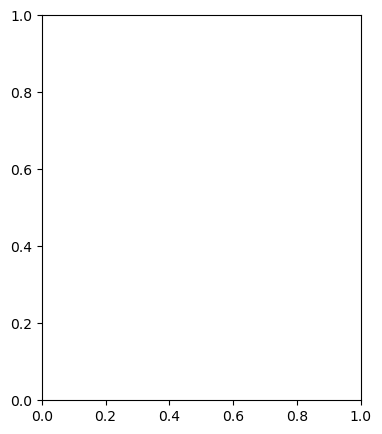

In [6]:
#%% saídas gráficas
plt.close('all')

# Instanciar uma figura
plt.figure(1,figsize=[14,5])

plt.subplot(1,3,1)
plt.plot(t,x[1,:], 'r-', lw=5)
plt.ylabel('Temperatura do reator, oC', fontsize=14)
plt.xlabel('Tempo, min', fontsize=14)
plt.axis([0, 10, 300, 450])
plt.xticks(range(0,11))
plt.yticks(range(300,500,50))

plt.subplot(1,3,2)
plt.plot(t,x[0,:],'b-', lw=5)
plt.ylabel('Concentração de reagente, mol/L', fontsize=14)
plt.xlabel('Tempo, min', fontsize=14)
plt.axis([0, 10, 0, 1])
plt.xticks(range(0,11))
plt.yticks(np.arange(0,1.1,0.1))

plt.subplot(1,3,3)
plt.plot(x[0,:],x[1,:], 'k-')
plt.ylabel('Temperatura do reator, oC', fontsize=14)
plt.xlabel('Concentração de reagente, mol/L', fontsize=14)
plt.title('Plano de fases: cA x T', fontweight='bold')

# Ajustar o preenchimento entre os subplots 
plt.tight_layout()
plt.show()

# salvar uma figura (extensão pode ser pdf, jpg, ...)
plt.savefig('aula01_model_implementation.tif')